In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tacoma as tc
from tacoma.drawing import edge_activity_plot
from tacoma.analysis import detailed_temporal_network_group_analysis
import networkx as nx
import graph_tool.all as gt
from multiprocessing import Pool
import os
import glob
import contact_networks as cn

In [29]:
34*60

2040

In [2]:
# df = pd.read_csv('./VF_data/pandemos_tra_tapas_modell.csv')[['p_id', 'activity_start_min', 'activity_duration_min', 'activity', 'loc_id_end']]

# Preprocess and export data

In [23]:
def map_pid(df):
    nodes = df.p_id.unique()
    unique_nodes = np.unique(nodes)
    node_int_dict = dict(zip(unique_nodes, np.arange(0, len(unique_nodes), 1)))
    df.p_id = df.p_id.map(node_int_dict)

    return df

In [24]:
def preprocess_data(df):
    # Load data

    # Get activities
    df_activities = pd.read_csv('./VF_data/activities.csv')
    df_activities[['name_tapas', 'code_tapas', 'name_zbe', 'code_zbe', 'name_mct', 'code_mct']].sort_values('code_zbe')
    activity_dict = {}

    for i, row in df_activities.iterrows():
        activity_dict[row.code_zbe] = row.name_mct

    df['activity_name_mct'] = df.activity.map(activity_dict)
    df['activity_end_min'] = df.activity_start_min + df.activity_duration_min

    # Find 24h range with the most activity
    tmin = df.activity_start_min.quantile(.0025)
    tmax = df.activity_end_min.quantile(.995)
    print(tmin, tmax)
    df = df[df.activity_start_min >= tmin]
    df = df[df.activity_end_min <= tmax]
    df.activity_start_min = df.activity_start_min - tmin
    df.activity_end_min = df.activity_end_min - tmin

    # p_id mapping
    df = map_pid(df)

    # Downcast and export
    df = df.astype({'activity_start_min': 'int16', 'activity_end_min': 'int16', 'p_id': 'uint32', 'activity': 'category', 'activity_name_mct': 'category'})
    df.to_parquet('./VF_data/rns_data_2.parquet')

#  Load exported data

In [25]:
# Load exportet data
df = pd.read_parquet('./VF_data/rns_data_2.parquet')[['p_id', 'activity_start_min', 'loc_id_end', 'activity_name_mct', 'activity_end_min']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13477747 entries, 0 to 13578536
Data columns (total 5 columns):
 #   Column              Dtype   
---  ------              -----   
 0   p_id                uint32  
 1   activity_start_min  int16   
 2   loc_id_end          int64   
 3   activity_name_mct   category
 4   activity_end_min    int16   
dtypes: category(1), int16(2), int64(1), uint32(1)
memory usage: 321.3 MB


# Location identifying 

In [26]:
locations = df.groupby('loc_id_end').size().sort_values(ascending=False).index.values

In [27]:
def find_locations():
    for i in range(1000, 1010):
        loc = df[df.loc_id_end == locations[i]]
        print(i, loc.activity_name_mct.value_counts(), '\n')

In [28]:
# Some example locations
loc1018 = df[df.loc_id_end == locations[1018]]
loc1003 = df[df.loc_id_end == locations[1003]]
loc1015 = df[df.loc_id_end == locations[1015]]
loc2101 = df[df.loc_id_end == locations[2101]]

loc1015 = map_pid(loc1015)
loc1003 = map_pid(loc1003)
loc1018 = map_pid(loc1018)
loc2101 = map_pid(loc2101)

/tmp/ipykernel_2485416/3302987772.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.p_id = df.p_id.map(node_int_dict)


# Baseline network
The baseline network is a fully connected network that is modulated by VF data. That means that nodes are activated or deactivated if they enter/leave the location according VF data. All nodes active at certain point in time are fully connected. 

In [29]:
def get_contacts(location):
    start_times, end_times = location.activity_start_min.values, location.activity_end_min.values
    event_ids = location.p_id.values
    loc_id_end = location.loc_id_end.values[0]
    # Takes a df containing all activities at location
    # Returns all possible contacts

    # Broadcast the start_time and end_time arrays for comparison with each other
    overlap_start = np.maximum.outer(start_times, start_times)
    overlap_end = np.minimum.outer(end_times, end_times)

    # Calculate the overlap duration matrix 
    overlap_durations = np.maximum(overlap_end - overlap_start, np.zeros(shape=overlap_start.shape)).astype('uint16')
    
    # Set diagonal elements to zero (overlap of an event with itself and double counting)
    overlap_durations = np.triu(overlap_durations, 1)

    # Extract contact rows, cols
    rows, cols = np.where(overlap_durations > 0)
    p_A = event_ids[rows].astype('int')

    # Save contacts to new DataFrame
    contact_data = {'p_A': p_A,'p_B': event_ids[cols].astype('int'), 
                    'start_of_contact': overlap_start[rows, cols].astype('int'),
                    'end_of_contact': overlap_end[rows, cols].astype('int'),
                    'loc_id': np.repeat(loc_id_end, len(p_A)).astype('int32')}

    return pd.DataFrame(contact_data)

In [30]:
def fully_connected_tn(contacts, p_id_unique):
    tn = tc.edge_changes()
    tmin, tmax = contacts.start_of_contact.min().astype(int) - 1, contacts.end_of_contact.max().astype(int)
    tn.N = p_id_unique
    tn.t0 = tmin
    tn.tmax = tmax
    tn.time_unit = 'm'
    event_times, edges_in, edges_out = [], [], []


    for t in range(tmin, tmax):
        start_events = contacts[contacts.start_of_contact == t]
        end_events = contacts[contacts.end_of_contact == t]

        if not start_events.empty:
            event_times.append(t)
            edges_in.append(list(zip(start_events.p_A, start_events.p_B)))
            
            if end_events.empty:
                edges_out.append([])

        if not end_events.empty:
            if start_events.empty:
                event_times.append(t)
                edges_in.append([])
            edges_out.append(list(zip(end_events.p_A.values, end_events.p_B.values)))
    
    tn.t = event_times
    tn.edges_in = edges_in
    tn.edges_out = edges_out
    tn.notes = 'None'
    return tn

def baseline_network(location):
    location = map_pid(location)
    contacts = get_contacts(location)
    return fully_connected_tn(contacts, location.p_id.unique().shape[0])

# Random network
The random network is a subset of the baseline network. It's created by taking a potential contact between nodes $i, j$ that are active at the same time in the location. Suppose their potential contact starts at $t_{\text{contact start}}$ and ends at $t_{\text{contact end}}$, than at every time step between $t_{\text{contact start}}$ and $t_{\text{contact end}}$ a real contact is generated with probability $p_{add}$. Every real contact has a duration of at least one time step. Additional real contact duration is choosen from an exponential distribution
$$
P(x; \beta) = \frac1\beta e^{x/\beta}.
$$
Where $\beta$ can be interpreted as the average additional contact duration. It may happen that real contacts overlap in this case the union of both contacts is generated. Creating multiedges in temporal networks is no option in dynamic networks. The method for creating the union of two overlapping real contacts (remove_multi_edges()) works not as intended in some cases. This will lead to errors reported in tc.verify(random_network). A possible workaround is to recreate the network with a different seed or to lower the values of $p_{add}$ and/or $\beta$ to reduce the probability of problematic edge cases. <br>
This network has two free parameters $p_{add}$ and $\beta$.

In [31]:
# Function dealing with multi edges. Creates union of two overlapping contacts
# arr1 and arr1 are an example of a problematic edge case
arr1 = np.array([395, 396, 399, 405, 10_000])
arr2 = np.array([400, 397, 400, 407, 10_001])

def remove_multi_edges(arr1, arr2):
    i = 0
    remove1, remove2 = [], []

    while i < arr1.size - 1:
        # Check for overlap
        if arr2[i] >= arr1[i + 1]:

            # Enter deletion mode
            j = i

            while (arr2[j] >= arr1[j+1]) and (j + 1 < arr1.size - 1):
                remove1.append(j + 1)
                j += 1

            ends = list(range(i, j + 1))
            del ends[np.argmax(arr2[i: j + 1])]
            remove2.extend(ends)
            
            i = j
        i += 1
    
    return np.delete(arr1, remove1), np.delete(arr2, remove2)

# remove_multi_edges(arr1, arr2)

In [32]:
def random_network(location, p_add, beta):
    location = map_pid(location)
    # Get all contacts
    contacts = get_contacts(location)
    contacts['duration'] = contacts.end_of_contact - contacts.start_of_contact 
    np.random.seed(1)
    
    edge_A, edge_B, edge_start, edge_end = [], [], [], [] 

    # Apply func
    def select_random_contacts(contact, p_add, beta):
        tstart, tend = contact.start_of_contact, contact.end_of_contact
        start = np.arange(tstart, tend, 1)[np.random.rand(contact.duration) < p_add]
        if start.size > 0:
            end = start + 1 + np.rint(np.random.exponential(beta, start.size)).astype('int')

            # handle multi edges
            start = np.append(start, 10_000)
            end = np.append(end, 10_001)
            start, end = remove_multi_edges(start, end)

            edge_A.extend(np.repeat(contact.p_A, start.size - 1))
            edge_B.extend(np.repeat(contact.p_B, start.size - 1))
            edge_start.extend(start[:-1])
            edge_end.extend(end[:-1])

    # Select random contacts
    contacts.apply(select_random_contacts, axis=1, args=(p_add, beta))
    selected_contacts = pd.DataFrame({'p_A': edge_A, 'p_B': edge_B, 'start_of_contact': edge_start, 'end_of_contact': edge_end})
    # return selected_contacts

    return fully_connected_tn(selected_contacts, location.p_id.unique().shape[0])

# Clique network
In the clique network locations are seperated into spaces. The number of people that fit at max into one space is given by $N_{peaoplePerSpace}$. The number of spaces of one location is calculated such that every space (except the last space) is completely filled if all nodes, that visit the location at at least one point in time, where active at the same time. Every node is assigned a random default space. Than for every node time series is created giving the current space of a node at a certain time. Nodes start in their default location and change spaces with probability $p_{\text{space change}}$ to a random space. Their stay at this space has a duration that is drawn from a normal distribution $\mathcal{N}(\mu, \sigma)$. Afterward the node goes back to its default space or during its stay another space change occurs drawing a new duration time from $\mathcal{N}(\mu, \sigma)$. <br>
This network has two four parameters $N_{peaoplePerSpace},\; p_{\text{space change}},\; \mu$ and $\sigma$.

In [33]:
def assign_spaces(location, N_peaoplePerSpace, p_space_change, mean, sigma):
    np.random.seed(1)
    # Get number of spaces
    nodes = location.p_id.unique()
    N_spaces = int(np.ceil(nodes.size / N_peaoplePerSpace)) + 1

    # Boundaries for time series
    ts0, tsmax = location.activity_start_min.min(), location.activity_end_min.max()
    time_series = np.zeros(shape=(nodes.size, tsmax - ts0))

    # Get default locations
    default_spaces = dict(zip(nodes, np.random.randint(1, N_spaces, size=nodes.size)))

    # Group people
    p_grouped = location.groupby('p_id')


    def match_time(trajectory, p_id, default_space):
        # this method return a time series that contains the space of each node, np.nan means the node is not present
        # np.random.seed(1)
        # Go trough trajectories
        # Assign default space
        trajectory_time_series = np.zeros(shape=(tsmax - ts0))  # zero corresponds to node is not in location
        tr_start, tr_end = trajectory.activity_start_min, trajectory.activity_end_min
        trajectory_time_series[tr_start: tr_end] = default_space

        # Assign random space
        space_changes = (np.arange(tr_start, tr_end, 1)[np.random.rand(tr_end - tr_start) < p_space_change]).astype('int')
        spaces = np.random.randint(1, N_spaces, space_changes.size).astype('int')
        space_change_durations = np.rint(np.random.normal(mean, sigma, space_changes.size)).astype('int')
        space_change_durations[space_change_durations < 1] = 1

        for space_change, space, duration in zip(space_changes, spaces, space_change_durations):
            trajectory_time_series[space_change: space_change + duration] = space
        
        time_series[p_id][trajectory_time_series > 0] = trajectory_time_series[trajectory_time_series > 0]

    def get_time_series(p_group):
        # Go through people
        default_space = default_spaces[p_group.name]
        return p_group.apply(match_time, axis=1, args=(p_group.name, default_space))



    p_grouped.apply(get_time_series)
    time_series[time_series == 0] = np.nan
    return time_series

In [34]:
# Helper function that returns the first and the last index of a block of consecutive True values in a 1d numpy array
# Example boolean 1D numpy array
bool_array = np.array([True, False, True, True, True, False, True, True, False, True, True])

def boolean_blocks_indices(bool_array):
    # Find the indices where the values change from False to True or True to False
    changes = np.where(np.diff(bool_array.astype(int)) != 0)[0] + 1

    # If the first element is True, insert 0 at the beginning
    if bool_array[0]:
        changes = np.insert(changes, 0, 0)

    # If the last element is True, append the array length
    if bool_array[-1]:
        changes = np.append(changes, len(bool_array))

    # Reshape the indices into pairs
    indices_pairs = changes.reshape(-1, 2)

    # Get the first and last index of each pair
    first_indices = indices_pairs[:, 0]
    last_indices = indices_pairs[:, 1] - 1

    return first_indices, last_indices

In [35]:
def check_space(contact, time_series, p_As, p_Bs, start_contacs, end_contacts, spaces):
    # Checks wether two nodes simultaniously present at location are at the same space
    p_A, p_B = contact.p_A, contact.p_B

    space_overlap = time_series[p_A, contact.start_of_contact: contact.end_of_contact] == time_series[p_B, contact.start_of_contact: contact.end_of_contact]
    space_contact_start, space_contact_end = boolean_blocks_indices(space_overlap)
    space_contact_start += contact.start_of_contact
    space_contact_end += contact.start_of_contact

    p_As.extend(np.repeat(p_A, space_contact_start.size))
    p_Bs.extend(np.repeat(p_B, space_contact_start.size))
    start_contacs.extend(space_contact_start)
    end_contacts.extend(space_contact_end)
    spaces.extend(time_series[p_A][space_contact_start])


def get_contacts_spaces(location, N_peaoplePerSpace, p_space_change, mean, sigma):
    # Map ids
    location = map_pid(location)

    contacts = get_contacts(location)
    time_series = assign_spaces(location, N_peaoplePerSpace, p_space_change, mean, sigma)

    p_As, p_Bs, start_contacs, end_contacts, spaces = [], [], [], [], []
    contacts.apply(check_space, axis=1, args=(time_series, p_As, p_Bs, start_contacs, end_contacts, spaces))

    space_contacts = pd.DataFrame({'p_A': p_As, 'p_B': p_Bs, 'start_of_contact': start_contacs, 'end_of_contact': end_contacts, 'space': spaces})

    space_contacts = space_contacts[(space_contacts.end_of_contact - space_contacts.start_of_contact) > 0]

    return space_contacts

In [36]:
def clique_network(location, N_peaoplePerSpace, p_space_change, mean, sigma):
    space_contacts = get_contacts_spaces(location, N_peaoplePerSpace, p_space_change, mean, sigma)
    return fully_connected_tn(space_contacts, location.p_id.unique().shape[0])

         p_id  activity_start_min  activity_end_min activity_name_mct
7709061    19                 362               917           WORKING
         p_id  activity_start_min  activity_end_min activity_name_mct
2422335   340                 457               757           WORKING


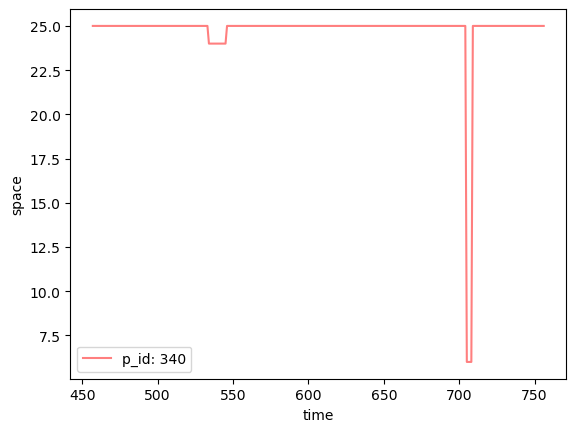

In [37]:
# test0 366, 479
# test1 419, 51
# tet2 366, 474

time_series = assign_spaces(loc1015, N_peaoplePerSpace=15, p_space_change=1/150, mean=10, sigma=5)
id = 19 
#plt.plot(np.arange(0, time_series[id].size, 1), time_series[id], alpha=.5, color='blue', label='p_id: ' + str(id))
print(loc1015[loc1015.p_id == id][['p_id', 'activity_start_min', 'activity_end_min', 'activity_name_mct']])

id = 340
plt.plot(np.arange(0, time_series[id].size, 1), time_series[id], alpha=.5, color='red', label='p_id: ' + str(id))
print(loc1015[loc1015.p_id == id][['p_id', 'activity_start_min', 'activity_end_min', 'activity_name_mct']])

plt.xlabel('time')
plt.ylabel('space')
plt.legend()

In [18]:
n_experiments = 10_000

def get_ts(p_inv):
    arr = np.random.rand(n_experiments, 1000)
    space_changes = arr < 1/p_inv
    time_series = np.zeros((n_experiments, 1000))
    time_series[time_series == 0] = 1

    durations = np.rint(np.random.normal(15, 5, space_changes.sum())).astype('int')
    durations[durations < 1] = 1

    rows, cols = np.where(space_changes)

    for duration, row, col in zip(durations, rows, cols):
        time_series[row, col: col+duration] = 0

    # prob = np.mean(time_series, axis=0)
    # plt.plot(np.arange(0, prob.size, 1), prob)
    return time_series

In [ ]:
for p in [50, 100, 150, 200]:
    ts1 = get_ts(p)
    ts2 = get_ts(p)

    contacts = np.zeros((n_experiments, 1000))
    contacts[ts1 == ts2] = 1

    prob = np.mean(contacts, axis=0)
    plt.plot(np.arange(0, prob.size, 1), prob, label=str(p))

plt.legend()

In [309]:
time_series = assign_spaces(loc1015, N_peaoplePerSpace=15, p_space_change=1/150, mean=10, sigma=5)
contact_ts = []
edge_list = []

for i, ts1 in enumerate(time_series):
    for j, ts2 in enumerate(time_series):
        contacts = ts1 == ts2

        if contacts.sum() > 0:
            contact_ts.append(contacts)
            edge_list.append((i, j))

contact_ts = np.array(contact_ts)
edge_list = np.array(edge_list)

In [19]:
def diy_edge_activity():
    time_series = assign_spaces(loc1015, N_peaoplePerSpace=15, p_space_change=1/150, mean=10, sigma=5)
    contact_ts = []
    edge_list = []

    for i, ts1 in enumerate(time_series):
        for j, ts2 in enumerate(time_series):
            contacts = ts1 == ts2

            if contacts.sum() > 0:
                contact_ts.append(contacts)
                edge_list.append((i, j))

    contact_ts = np.array(contact_ts)
    edge_list = np.array(edge_list)

    rows, first_true = np.where(contact_ts.cumsum(axis=1).cumsum(axis=1) == 1)
    rows[np.argsort(first_true)]

    fig, ax = plt.subplots(figsize=(20, 10))
    print(ax)
    ax.imshow(contact_ts[np.argsort(first_true)], aspect=.05, cmap='binary')
    #ax.set(ylim=(5160, 5200))
    #ax.hlines(5175, 200, 1000, colors='red', alpha=.3)

    #print(edge_list[np.argsort(first_true)][5175: 5200])

# Some interesting first network measures

In [20]:
def networks(location):
    # If tc.verify() returns something other than 0 some tacoma methods maybe behave incorrect.
    b = baseline_network(loc1015)
    r = random_network(loc1015, .03, .1)
    c = clique_network(loc1015, N_peaoplePerSpace=15, p_space_change=1/100, mean=10, sigma=5)

    print(tc.verify(r), tc.verify(b), tc.verify(c))
    return b, r, c

In [21]:
def plot_edge_counts(b, r, c):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    _, _, m_base = tc.edge_counts(b)
    _, _, m_random = tc.edge_counts(r)
    _, _, m_clique = tc.edge_counts(c)

    m_base_tot = np.max(np.array(m_base))
    m_random_tot = np.max(np.array(m_random))
    m_clique_tot = np.max(np.array(m_clique))

    ax1.plot(b.t, m_base[1:], label='baseline')
    ax1.plot(r.t, m_random[1:], label='random')
    ax1.plot(c.t, m_clique[1:], label='clique')

    ax2.plot(b.t, np.array(m_base[1:])/m_base_tot, label='baseline normalized', alpha=1)
    ax2.plot(r.t, np.array(m_random[1:])/m_random_tot, label='random normalized', alpha=.5)
    ax2.plot(c.t, np.array(m_clique[1:])/m_clique_tot, label='clique normalized', alpha=.5)

    for ax, ylabel in zip((ax1, ax2), ('edge counts', 'edge counts normalized')):
        ax.set_xlabel('time')
        ax.set_ylabel(ylabel)
        ax.legend()

    plt.tight_layout()

# plot_edge_counts()

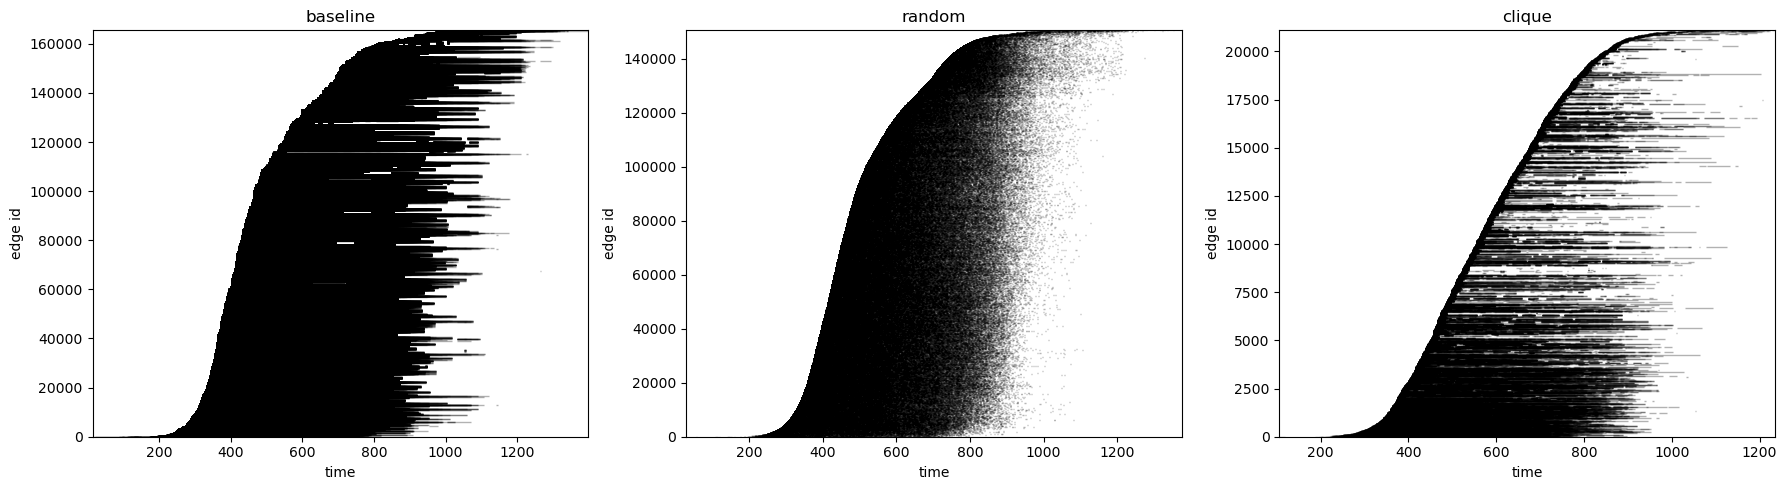

In [40]:
def edge_activity_plots():
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    for ax, network, title in zip(axs.flatten(), (b, r, c), ('baseline', 'random', 'clique')):
        edge_activity_plot(network, ax=ax, alpha=.3)
        ax.set(title=title, xlabel='time', ylabel='edge id')

    plt.tight_layout()

edge_activity_plots()

Edge activity plots assign every edge, in order of their appereance, an id. If an edge is active at time $t$ a black dot is drawn and white dot if not. We observe that the random network has the same characteristics as the baseline network edges are just randomly turned of and on if they are on in the baseline network. For the clique network we observe distinctive white lines parallel to initial activation line. I suspect that the distance between those lines is related to $1/p_{\text{space change}}$ as this is the expectation value for the first space change.

In [23]:
def get_nedges(network):
    _, _, m = tc.edge_counts(network)
    return np.sum(np.array(m))

In [24]:
def simulate_SIR(i, r, network, days, tmax):
    SIR = tc.SIR(network.N, days*network.tmax, i, r)
    tc.gillespie_SIR(network, SIR)

    events = np.rint(np.array(SIR.time)).astype(int)
    #tmax = np.max(events) + 1

    time = np.arange(0, tmax, 1)
    I, R = np.empty(tmax), np.empty(tmax)
    I[:] = np.nan
    R[:] = np.nan

    I[events] = SIR.I
    R[events] = SIR.R

    I = pd.Series(I).ffill().values
    R = pd.Series(R).ffill().values

    I[np.isnan(I)] = 0
    R[np.isnan(R)] = 0

    return time, I, R

# Load precomputed SIR runs

In [47]:
def load_data_save_mean(runss=[5120, 6350, 8090, 6900], locations=[2101, 1015, 1003, 1018], networks=['baseline', 'random', 'clique']):
    # Load data and save mean
    for runs, location in zip(runss, locations):
        for network in networks:
            path = '/hpc_data/dial_mo/contact_modeling/dynamic_nets/'
            file = f'simulation_numRuns_{runs}_data_location_{location}_days_30_NppS_15_p_change_0.01_mean_10_sigma_5_p_add_0.03_r_beta_0.1_{network}.npy'

            I = np.load(path + file)
            I = np.mean(I, axis=0)
            np.save(f'./data_SIR_runs/mean_{file}', I)

In [48]:
def load_dynamic_SIR_runs():
    # Load mean
    I_dir = {}
    for runs, location, location_short in zip([5120, 6350, 8090, 6900], [2101, 1015, 1003, 1018], ['B', 'C', 'A', 'D']):
        for network in ['baseline', 'random', 'clique']:
            path = '/hpc_data/dial_mo/contact_modeling/dynamic_nets/'
            file = f'mean_simulation_numRuns_{runs}_data_location_{location}_days_30_NppS_15_p_change_0.01_mean_10_sigma_5_p_add_0.03_r_beta_0.1_{network}.npy'
            
            I_dir[location_short + network[0]] = np.load(f'./data_SIR_runs/{file}')
    
    return I_dir

# Static Network aggregation

In [26]:
# Set gt multiprocessing
gt.openmp_set_num_threads(1)

In [55]:
# Get static network representation of dynamic network

'''
r_static_edgedict = tc.aggregated_network(r)
b_static_edgedict = tc.aggregated_network(b)
c_static_edgedict = tc.aggregated_network(c)

def edgedict_to_edgelist(edgedict):
    return [(v1, v2, int(w)) for (v1, v2), w in edgedict.items()]

c_static_edgelist = edgedict_to_edgelist(c_static_edgedict)
b_static_edgelist = edgedict_to_edgelist(b_static_edgedict)
r_static_edgelist = edgedict_to_edgelist(r_static_edgedict)

def static_network(edgelist, beta):
    G = gt.Graph(edgelist[:, :-1], directed=False)

    duration_weight = G.new_edge_property('double', beta*edgelist[:, -1]/(get_nedges(c)*24*60))
    G.ep['duration_weight'] = duration_weight

    return G
'''

def convert_dynamic_static(network_dynamic, beta):
    # Takes a dynamic tacoma style network and return the corresponding static graph-tool style networ
    edge_dict = tc.aggregated_network(network_dynamic) 
    edge_list = np.array([(v1, v2, int(w)) for (v1, v2), w in edge_dict.items()])

    G = gt.Graph(edge_list[:, :-1], directed=False)
    duration_weight = G.new_edge_property('double', beta*edge_list[:, -1]/(get_nedges(network_dynamic)*24*60))
    G.ep['duration_weight'] = duration_weight

    return G

def get_static_network(location, network_type, beta):
    if network_type == 'baseline':
        network = baseline_network(location)
    
    elif network_type == 'random':
        network = random_network(location, .03, .1)
    
    elif network_type == 'clique':
        network = clique_network(location, N_peaoplePerSpace=15, p_space_change=1/100, mean=10, sigma=5)

    return convert_dynamic_static(network, beta)

In [69]:
# Perform SIR runs on static network utilizing multiple cores
locations = [loc1015, loc2101, loc1018, loc1003]
location_names = [1015, 2101, 1018, 1003]
beta = 600
loops = 100
runss = [64, 52, 69, 81]
worker = 25

sim_i = 3
location = locations[sim_i]
location_name = location_names[sim_i]
runs = runss[sim_i]
network_type = 'clique'

print('Building network')
G = get_static_network(location, network_type, beta)

def gt_SIR_runs(id=None, network_name=None):
    Ss, Is, Rs = np.zeros(50_000), np.zeros(50_000), np.zeros(50_000)

    for run in range(runs):
        S, I, R = [], [], []
        state = gt.SIRState(G, beta=G.ep.duration_weight, gamma=beta/100_00_000, constant_beta=True)

        for t in range(50_000):
            ret = state.iterate_sync()
            s = state.get_state().fa

            S.append((s == 0).sum())
            I.append((s == 1).sum())
            R.append((s == 2).sum())
        
        Ss += S
        Is += I
        Rs += R

    S, I, R = (Ss/runs).astype('uint16'), (Is/runs).astype('uint16'), (Rs/runs).astype('uint16')
    np.save(f'./data_SIR_runs/{network_type}/S/S_{str(id).zfill(3)}_{network_type}_runs={runs}_beta={beta}.npy', S)
    np.save(f'./data_SIR_runs/{network_type}/I/I_{str(id).zfill(3)}_{network_type}_runs={runs}_beta={beta}.npy', I)
    np.save(f'./data_SIR_runs/{network_type}/R/R_{str(id).zfill(3)}_{network_type}_runs={runs}_beta={beta}.npy', R)
    print(f'finished run with id: {id}')

    return S, I, R

def parallelized_gt_SIR_runs(id):
    print(f'start run with id: {id}')
    gt_SIR_runs(id)

    return None

print('Starting simulation')
with Pool(processes=worker) as pool:
    results = pool.imap_unordered(parallelized_gt_SIR_runs, range(loops))

    for res in results:
        pass

print('Finished simulation \n Summarize data')
def convert_static_SIR_runs_to_mean(network_name, location, nruns):
    path = f'./data_SIR_runs/{network_name}/'

    runs = len(os.listdir(f'{path}/S'))
    S0 = os.listdir(f'{path}/S')[0]
    tsteps = np.load(f'{path}/S/{S0}').size
    compartments = {'S': np.zeros(tsteps), 'I': np.zeros(tsteps), 'R': np.zeros(tsteps)}

    for compartment in ['S', 'I', 'R']:
        for file in os.listdir(f'{path}/{compartment}'):
            compartments[compartment] += np.load(f'{path}/{compartment}/' + file)
    
    for compartment in ['S', 'I', 'R']:
        if compartment == 'I':
            compartments[compartment] = compartments[compartment]/runs
            directory = './data_SIR_runs/'
            file = f'mean_static_runs_{nruns}_location_{location}_network_{network_name}.npy'
            np.save(directory + file, compartments['I'])
        
        # remove files from temporary folder
        files = glob.glob(f'./data_SIR_runs/{network_name}/{compartment}/*')
        for f in files:
            os.remove(f)

    
    return compartments.values()

convert_static_SIR_runs_to_mean(network_type, location_name, loops*runs)
pass

Building network


/tmp/ipykernel_3213402/3302987772.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.p_id = df.p_id.map(node_int_dict)


Starting simulation
start run with id: 0start run with id: 1start run with id: 2start run with id: 3
start run with id: 13start run with id: 5start run with id: 4start run with id: 8start run with id: 7start run with id: 6start run with id: 11start run with id: 10start run with id: 9start run with id: 23start run with id: 14start run with id: 12start run with id: 15
start run with id: 16
start run with id: 17start run with id: 19start run with id: 18
start run with id: 20
start run with id: 24start run with id: 22start run with id: 21



















finished run with id: 19
start run with id: 25
finished run with id: 14
start run with id: 26
finished run with id: 4
start run with id: 27
finished run with id: 1
start run with id: 28
finished run with id: 22
start run with id: 29
finished run with id: 7
start run with id: 30
finished run with id: 12
start run with id: 31
finished run with id: 21
start run with id: 32
finished run with id: 6
start run with id: 33
finished run with id:

dict_values([array([80675., 80650., 80650., ..., 51325., 51325., 51325.]), array([ 1.,  1.,  1., ..., 33., 33., 33.]), array([    0.,     0.,     0., ..., 26000., 26000., 26000.])])

In [83]:
def load_mean_static_SIR(network_name, location, nruns):
    directory = './data_SIR_runs/'
    file = f'mean_static_runs_{nruns}_location_{location}_network_{network_name}.npy'

    return np.load(directory + file)

def plot_SIR_runs_static_dynamic(location, nruns, nruns_dynamic):
    for network, color in zip(['baseline', 'random', 'clique'], ['#1f77b4', '#ff7f0e', '#2ca02c']):
        I_static = np.load(f'./data_SIR_runs/mean_static_runs_{nruns}_location_{location}_network_{network}.npy')
        I_dynamic = np.load(f'./data_SIR_runs/mean_simulation_numRuns_{nruns_dynamic}_data_location_{location}_days_30_NppS_15_p_change_0.01_mean_10_sigma_5_p_add_0.03_r_beta_0.1_{network}.npy')

        T = np.arange(I_static.size) / (24*60)
        plt.plot(T, I_static, label=network, linestyle='--')
        plt.plot(T, I_dynamic, label=f'{network} (dynamic)', linestyle='-', color=color)

    plt.legend()
    # plt.title('Dynamic vs. Static Networks')
    plt.xlim(0, 20)
    plt.xlabel('time [d]')
    plt.ylabel('infected nodes')
    plt.savefig(f'./plots/dynamic_static_sir_{location_name}_{nruns}.pdf')
    plt.savefig(f'./plots/dynamic_static_sir_{location_name}_{nruns}.png')
    plt.close()

In [86]:
plt.rcParams.update({'font.size': 13})
location_names = [1015, 2101, 1018, 1003]
runss = [64, 52, 69, 81]
runss_dynamic = [6350, 5120, 6900, 8090]

for location_name, runs, runs_dynamic in zip(location_names, runss, runss_dynamic):
    plot_SIR_runs_static_dynamic(location_name, runs*100, runs_dynamic)
    

In [123]:
c = clique_network(loc1015, N_peaoplePerSpace=100, p_space_change=1/600, mean=10, sigma=5)
tc.verify(c)

/tmp/ipykernel_2069101/3302987772.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.p_id = df.p_id.map(node_int_dict)


0

In [185]:
c_static_edgedict = tc.aggregated_network(c)
c_static_edgelist = edgedict_to_edgelist(c_static_edgedict)

In [199]:
G = static_network(np.array(c_static_edgelist), 600)
largest_comp = gt.GraphView(G, vfilt = gt.label_largest_component(G))
pos = gt.sfdp_layout(largest_comp, eweight=G.ep.duration_weight)

In [ ]:
plt.figure
gt.graph_draw(largest_comp, pos=pos, vprops={'size': 2}, eprops={'pen_width': .04, 'color': [0.179, 0.203, 0.210, 0.8]}, bg_color='white', output_size=(1000, 1000))

# Export Network Snapshots

In [124]:
c = clique_network(loc1015, N_peaoplePerSpace=60, p_space_change=1/150, mean=10, sigma=5)
tc.verify(c)

/tmp/ipykernel_2069101/3302987772.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.p_id = df.p_id.map(node_int_dict)


0

In [30]:
from copy import deepcopy
from scipy.sparse import csc_matrix

class sparse_adjacency_matrices():
    """
    Construct a temporal network as a list of sparse adjacency matrices.

    Parameters
    ----------
    temporal_network : :class:`_tacoma.edge_changes`, :class:`_tacoma.edge_lists`, :class:`_tacoma.edge_changes_with_histograms`, or :class:`_tacoma.edge_lists_with_histograms`
        An instance of a temporal network.
    sparse_generator : instance of ``scipy.sparse`` matrix, default : ``scipy.sparse.csc_matrix``
        The sparse matrix class with which to construct all adjacency matrices.
    dtype : numpy.dtype, default=float
        Data type of the matrix entries.
    """

    def __init__(self,temporal_network,sparse_generator=csc_matrix,dtype=float):

        self.t = np.array(temporal_network.t)
        self.N = deepcopy(temporal_network.N)
        self.int_to_node = deepcopy(temporal_network.int_to_node)
        self.notes = deepcopy(temporal_network.notes)
        self.time_unit = deepcopy(temporal_network.time_unit)
        self.tmax = deepcopy(temporal_network.tmax)
        self.sparse_generator = sparse_generator
        self.dtype = dtype

        self._generate_adjacency_matrices(temporal_network.edges)

    def _generate_adjacency_matrices(self,edges):

        self.adjacency_matrices = []

        for this_el in iter(edges):
            coords = np.array(this_el,dtype=int)
            if coords.size > 0:
                i, j = coords[:,0], coords[:,1]
                iall = np.concatenate((i,j))
                jall = np.concatenate((j,i)) 
                data = np.ones_like(iall,dtype=float)
                A = self.sparse_generator((data, (iall, jall)), shape=(self.N, self.N))
            
            else:
                A = self.sparse_generator(([], ([], [])), shape=(self.N, self.N))

            self.adjacency_matrices.append(A)

def get_sparse_adjacency_matrices(G_ec):
    return sparse_adjacency_matrices(tc.convert(G_ec)).adjacency_matrices

Adj_list = get_sparse_adjacency_matrices(c)

In [31]:
def aggregate_adjacency_list(Adj_list):
    Adj_agg = Adj_list[0]

    for Adj in Adj_list[1:]:
        Adj_agg = Adj_agg + Adj

    return Adj_agg/len(Adj_list)

Adj_agg = aggregate_adjacency_list(Adj_list)

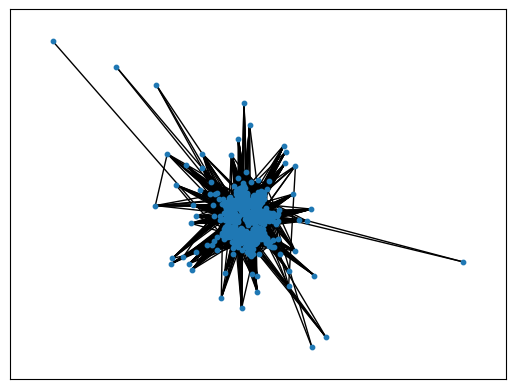

In [51]:
G_agg = nx.from_scipy_sparse_array(Adj_agg)
outliers = list(nx.isolates(G_agg))
G_agg.remove_nodes_from(outliers)
pos = nx.spring_layout
pos = nx.draw_networkx(G_agg, with_labels=False, node_size=10)


In [58]:
G = nx.from_scipy_sparse_array(Adj_list[123])
G.remove_nodes_from(outliers)
#G.remove_nodes_from(list(nx.isolates(G)))

In [52]:
pos = nx.spring_layout(G_agg, scale=5)

(-1.2, 1.2) (-1.2, 1.2)


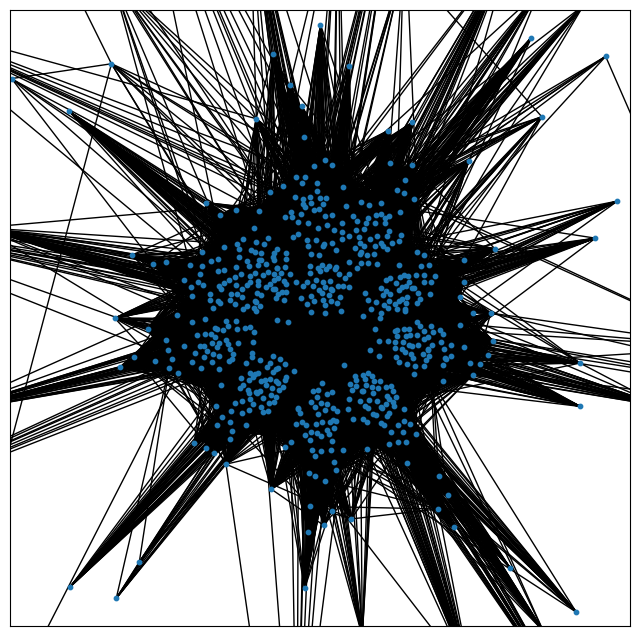

In [54]:
fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx(G_agg, with_labels=False, pos=pos, ax=ax, node_size=10)
lim = 1.2
ax.set(xlim=(-lim, lim), ylim=(-lim, lim))
print(ax.get_xlim(), ax.get_ylim())

(-1.2, 1.2) (-1.2, 1.2)


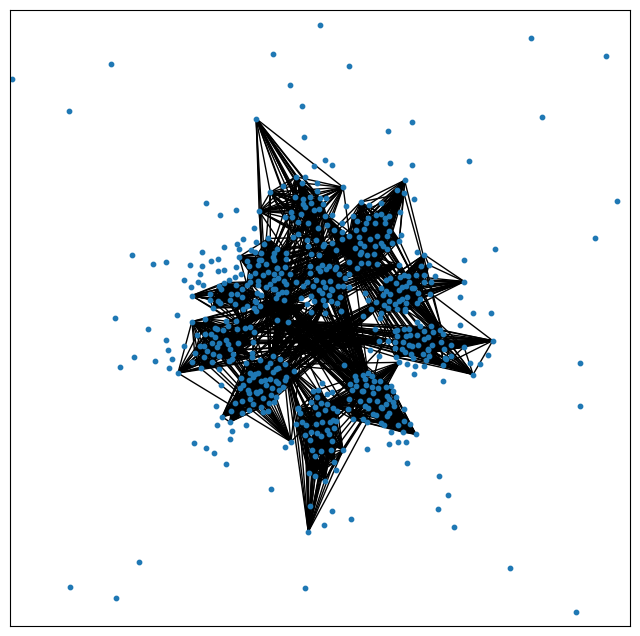

In [63]:
G = nx.from_scipy_sparse_array(Adj_list[654])
G.remove_nodes_from(outliers)

fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx(G, with_labels=False, pos=pos, ax=ax, node_size=10)
lim = 1.2
ax.set(xlim=(-lim, lim), ylim=(-lim, lim))
print(ax.get_xlim(), ax.get_ylim())

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


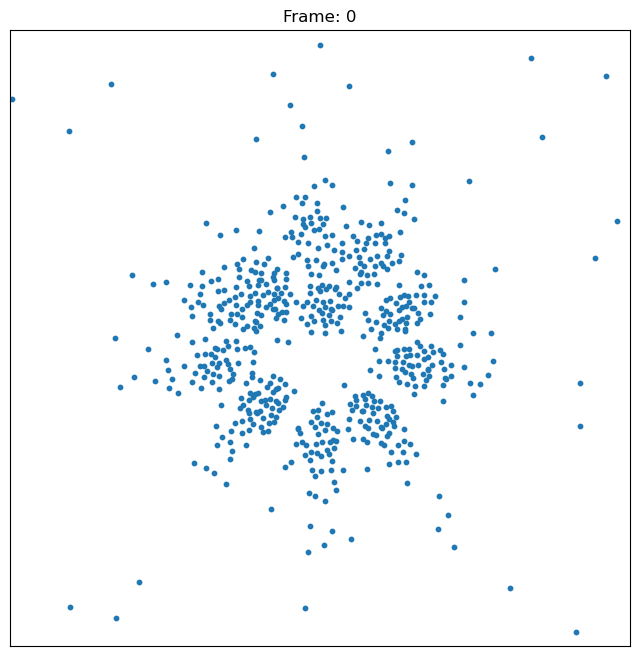

In [79]:
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(8,8))

def animate(i):
    plt.clf()
    lim = 1.2
    plt.xlim((-lim, lim))
    plt.ylim((-lim, lim))
    print(i)
    G = nx.from_scipy_sparse_array(Adj_list[i])
    G.remove_nodes_from(outliers)

    # fig, ax = plt.subplots(figsize=(8,8))
    nx.draw_networkx(G, with_labels=False, pos=pos, node_size=10)
    plt.title(f'Frame: {i}')

ani = FuncAnimation(fig, animate, range(len(Adj_list)), interval=50)
# ani = FuncAnimation(fig, animate, range(200), interval=50)
ani.save('test.gif')

In [94]:
import pickle

with open('./threshold/adj_list.pkl', 'wb') as f:  # open a text file
    pickle.dump(Adj_list, f, protocol=2) # serialize the list

In [95]:
with open('./threshold/adj_list.pkl', 'rb') as f:
    Adj_list = pickle.load(f) # deserialize using load()

In [97]:
lG = [nx.from_scipy_sparse_array(Adj) for Adj in Adj_list]

In [99]:
with open('./threshold/adj_list.pkl', 'wb') as f:  # open a text file
    pickle.dump(lG, f, protocol=2) # serialize the list

# Contact duration histogram

In [3]:
from tacoma.analysis import plot_contact_durations

In [15]:
tn = tc.edge_changes()
tn.N = 8
tn.t0 = 0.0
tn.t = [ 1.0, 1.5, 3.0, 4.0, 7.0, 7.31 ]
tn.tmax = 8.1
tn.edges_initial = [ (0, 1), (1, 7) ]
tn.edges_in = [
                [],
                [ (1, 7) ],
                [ (2, 5) ],
                [],
                [ (0, 1) ],
                []
              ]
tn.edges_out = [
                [ (1, 7) ],
                [],
                [ (0, 1) ],
                [ (1, 7) ],
                [],
                [ (2, 5) ]
               ]
tn.time_unit = 's'

result = tc.api.measure_group_sizes_and_durations(tn)
print(result.group_durations[1])
result.contact_durations

[0.5, 4.0, 3.0]


[2.5, 4.31]

/home/scho_jj/.conda/envs/pandemic_networks_env/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/home/scho_jj/.conda/envs/pandemic_networks_env/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


{'contact': (array([1.11612317, 1.39038917, 1.73205081, 2.15766928, 2.68787538]),
  array([2.32542378, 0.        , 0.        , 0.30072488, 0.48280873])),
 'inter-contact': (array([1., 1., 1., 1., 1.]),
  array([nan, nan, nan, nan, inf]))}

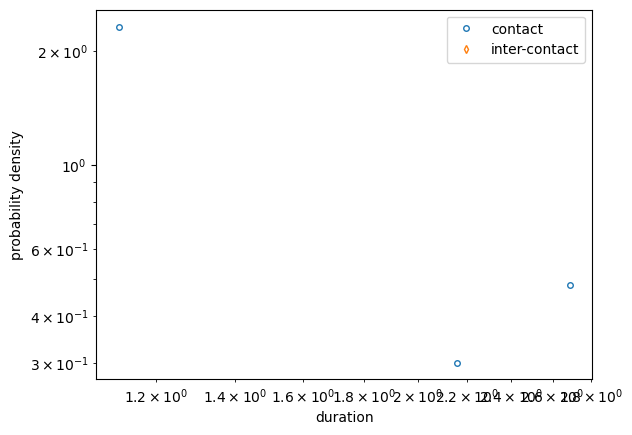

In [10]:
fig, ax = plt.subplots()
plot_contact_durations(result, ax, bins=5)

In [38]:
location = loc1015
b = baseline_network(location)
r = random_network(location, .03, .1)
c = clique_network(location, N_peaoplePerSpace=15, p_space_change=1/100, mean=10, sigma=5)

/tmp/ipykernel_2485416/3302987772.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.p_id = df.p_id.map(node_int_dict)
/tmp/ipykernel_2485416/3302987772.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.p_id = df.p_id.map(node_int_dict)


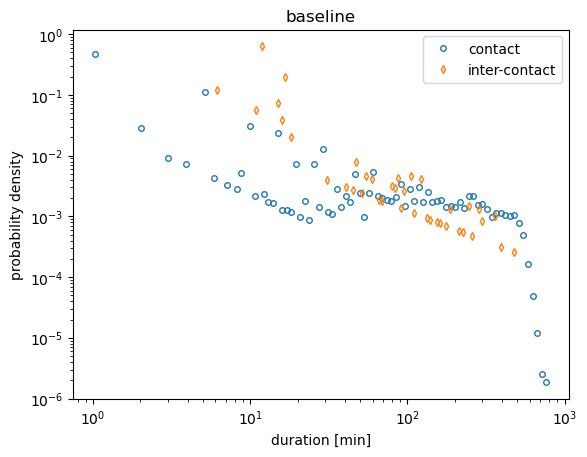

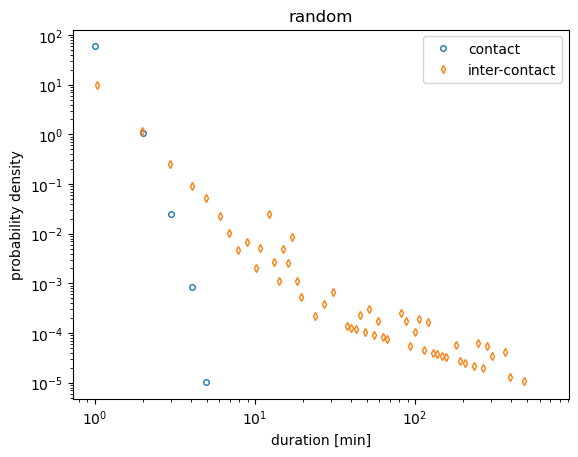

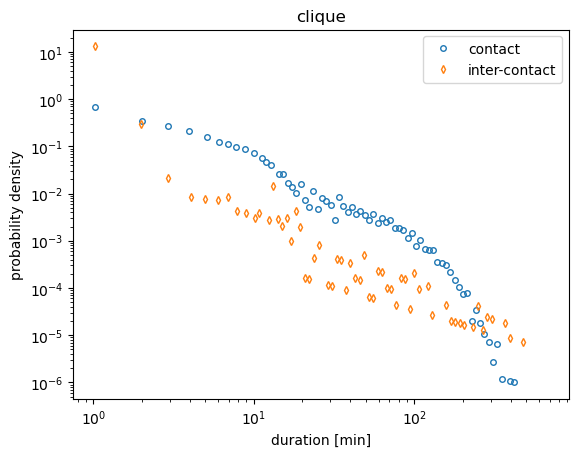

In [39]:
for n, n_type in zip([b, r, c], ['baseline', 'random', 'clique']):
    result = tc.api.measure_group_sizes_and_durations(n)
    result.contact_durations
    fig, ax = plt.subplots()
    ax.set_title(n_type)
    plot_contact_durations(result, ax, bins=100, xlabel='duration [min]')
    plt.savefig(f'./plots/paper/durations_{n_type}.png')